[*********************100%%**********************]  8 of 8 completed


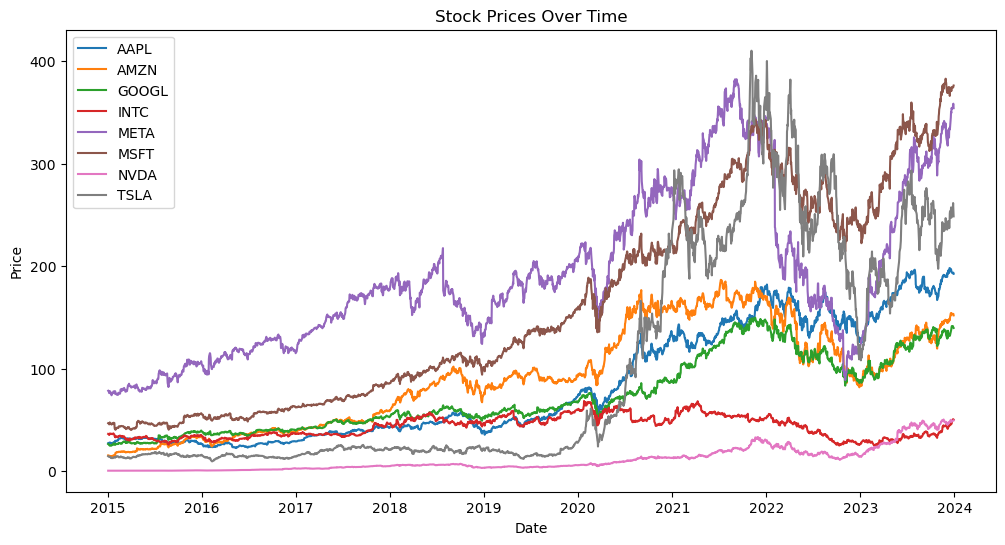

Cointegration Test AAPL-MSFT: p-value = 0.1658
Cointegration Test AAPL-GOOGL: p-value = 0.2687
Cointegration Test AAPL-AMZN: p-value = 0.9164
Cointegration Test AAPL-META: p-value = 0.8020
Cointegration Test AAPL-NVDA: p-value = 0.8667
Cointegration Test AAPL-TSLA: p-value = 0.2409
Cointegration Test AAPL-INTC: p-value = 0.9903
Cointegration Test MSFT-GOOGL: p-value = 0.2524
Cointegration Test MSFT-AMZN: p-value = 0.9423
Cointegration Test MSFT-META: p-value = 0.7569
Cointegration Test MSFT-NVDA: p-value = 0.9388
Cointegration Test MSFT-TSLA: p-value = 0.5525
Cointegration Test MSFT-INTC: p-value = 0.9909
Cointegration Test GOOGL-AMZN: p-value = 0.7903
Cointegration Test GOOGL-META: p-value = 0.6408
Cointegration Test GOOGL-NVDA: p-value = 0.7542
Cointegration Test GOOGL-TSLA: p-value = 0.0368
Cointegration Test GOOGL-INTC: p-value = 0.9592
Cointegration Test AMZN-META: p-value = 0.3411
Cointegration Test AMZN-NVDA: p-value = 0.8948
Cointegration Test AMZN-TSLA: p-value = 0.5381
Cointe

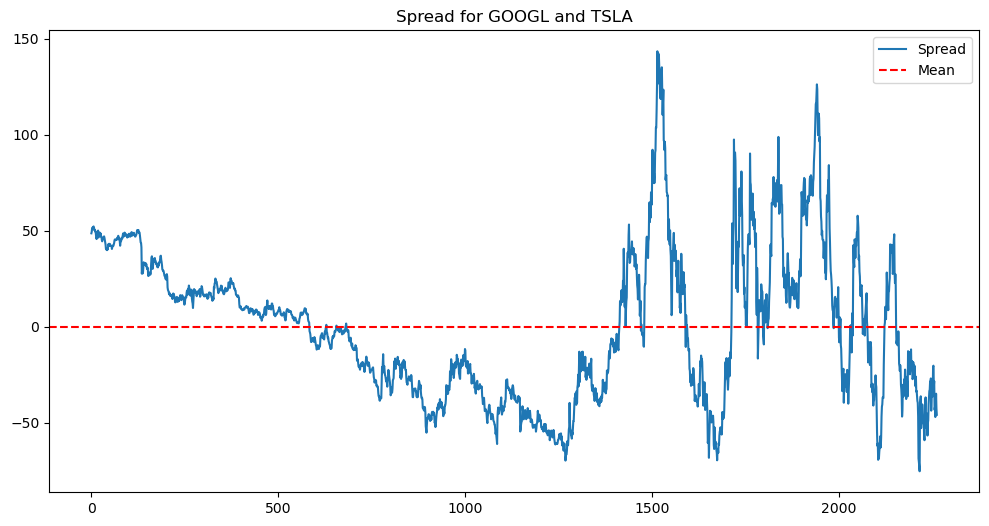

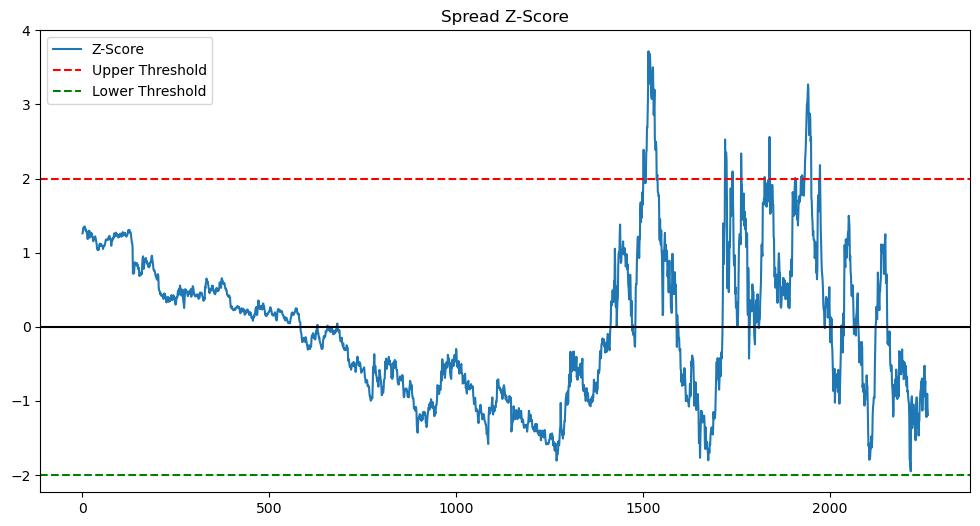

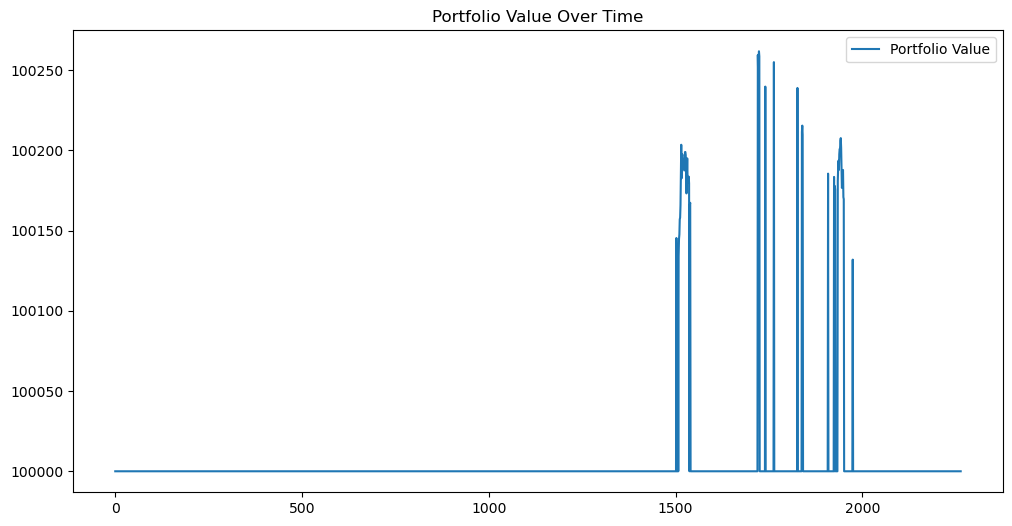

Sharpe Ratio: 0.0017
Maximum Drawdown: -261.70


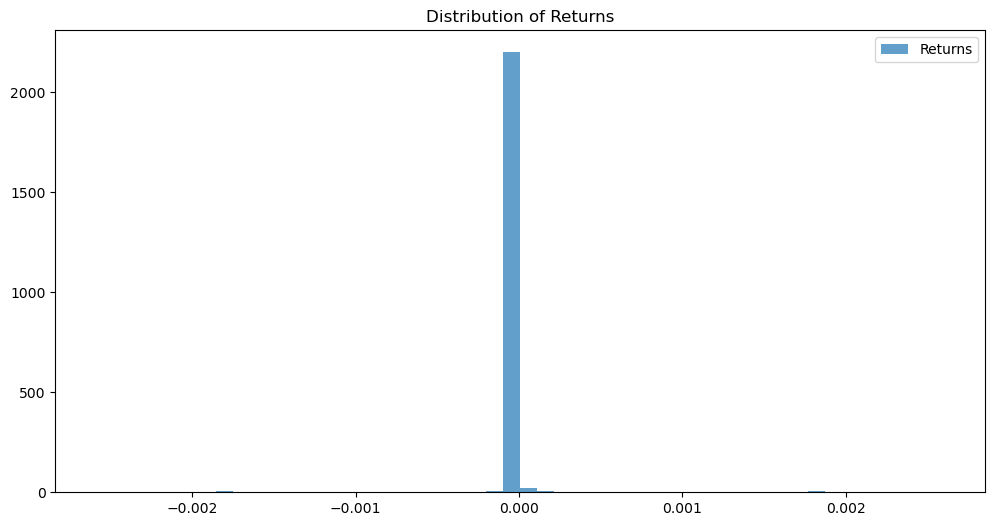

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, coint
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime

# Helper Functions
def download_data(tickers, start_date, end_date):
    """Download historical price data for given tickers."""
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    data.dropna(inplace=True)
    return data

def plot_prices(data):
    """Plot the historical prices of stocks."""
    plt.figure(figsize=(12, 6))
    for column in data.columns:
        plt.plot(data[column], label=column)
    plt.title("Stock Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

def stationarity_test(series, ticker_name):
    """Check if a series is stationary."""
    result = adfuller(series)
    print(f"{ticker_name} ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    return result[1]

def cointegration_test(data1, data2):
    """Check cointegration between two series."""
    score, p_value, _ = coint(data1, data2)
    return p_value

def compute_z_score(series):
    """Compute Z-score for a series."""
    return (series - series.mean()) / series.std()

# Step 1: Data Acquisition
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'INTC']  # Add more tickers for diversity
start_date = "2015-01-01"
end_date = "2023-12-31"

data = download_data(tickers, start_date, end_date)
plot_prices(data)

# Step 2: Pair Selection Based on Cointegration
pairs = []
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        t1, t2 = tickers[i], tickers[j]
        p_value = cointegration_test(data[t1], data[t2])
        print(f"Cointegration Test {t1}-{t2}: p-value = {p_value:.4f}")
        if p_value < 0.1:  # Adjust threshold for cointegration
            pairs.append((t1, t2))

if not pairs:
    print("No cointegrated pairs found. Adjust the tickers or threshold.")
    pairs = [(tickers[0], tickers[1])]  # Fallback to first two tickers

print(f"Selected Pairs: {pairs}")

# Step 3: Linear Regression for Spread Modeling
pair = pairs[0]  # Focus on the first pair
X = data[pair[0]].values.reshape(-1, 1)
y = data[pair[1]].values
model = LinearRegression()
model.fit(X, y)
spread = y - model.predict(X)
z_score = compute_z_score(spread)

# Plot Spread and Z-Score
plt.figure(figsize=(12, 6))
plt.plot(spread, label="Spread")
plt.axhline(spread.mean(), color='red', linestyle="--", label="Mean")
plt.title(f"Spread for {pair[0]} and {pair[1]}")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(z_score, label="Z-Score")
plt.axhline(2, color='red', linestyle="--", label="Upper Threshold")
plt.axhline(-2, color='green', linestyle="--", label="Lower Threshold")
plt.axhline(0, color='black', linestyle="-")
plt.title("Spread Z-Score")
plt.legend()
plt.show()

# Step 4: Backtesting
capital = 100000  # Starting capital
positions = []
portfolio = []

for i in range(len(z_score)):
    if z_score[i] > 2:  # Short spread
        positions.append((-1, 1))  # Short stock 1, long stock 2
    elif z_score[i] < -2:  # Long spread
        positions.append((1, -1))  # Long stock 1, short stock 2
    else:
        positions.append((0, 0))  # Close positions

# Simulating portfolio value
for i in range(len(data)):
    pos = positions[i]
    stock1_price = data[pair[0]].iloc[i]
    stock2_price = data[pair[1]].iloc[i]
    portfolio.append(capital + pos[0] * stock1_price + pos[1] * stock2_price)

# Plot Portfolio Value
plt.figure(figsize=(12, 6))
plt.plot(portfolio, label="Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.legend()
plt.show()

# Step 5: Performance Metrics
returns = np.diff(portfolio) / portfolio[:-1]
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
max_drawdown = np.min(portfolio) - np.max(portfolio)
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}")

# Final Report
plt.figure(figsize=(12, 6))
plt.hist(returns, bins=50, alpha=0.7, label="Returns")
plt.title("Distribution of Returns")
plt.legend()
plt.show()
